# Le Meridien Results (Step-by-Step, No Coding Needed)

This notebook is written for non-coders. Every section tells you:
- What we are doing and why it matters.
- Which table or chart to look at.
- Where the numbers get saved so you can open them in Excel and make your own charts.

**Data basics**
- Source file: `data/Hotel Brands_raw_data_indiv_lvl.csv` (placeholders ['#NULL!', 'NULL'] are turned into blank cells).
- Size: 385 people × 441 columns with 72,100 missing cells across 433 columns.
- Meridien reach: 361 people (93.8%) reported at least one Meridien stay; only 13 answered every Meridien opinion + SCR question, so conclusions stay cautious.
- SCR responses: 19 people gave an `SCRmerid` score; their average is 0.047 on a 0–1 scale (1 = strongest advocacy).

**Where to find ready-to-use tables for Excel**
We save CSV files into the `exports/` folder as we go (e.g., `exports/trip_summary.csv`). You can open them in Excel directly.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from helper import count_nulls

# Set a clean visual style and nicer number display
sns.set_theme(style='whitegrid', context='talk')
pd.options.display.float_format = '{:,.2f}'.format


## 1) Load the data once
Purpose: Make the dataset available for every section. Nothing to edit.
What to look at: The first five rows confirm the file opened correctly.


In [2]:
# Load the CSV once so every section uses the same data
DATA_PATH = Path('data/Hotel Brands_raw_data_indiv_lvl.csv')
NA_VALUES = ['#NULL!','NULL']

# Read the file and immediately convert placeholder strings to actual missing values (NaN)
df = pd.read_csv(DATA_PATH, na_values=NA_VALUES)
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]:,} columns")

# Peek at the first five rows to confirm structure
df.head()


Loaded 385 rows and 441 columns


,StartDate,EndDate,Status,Progress,Duration__in_seconds_,Finished,RecordedDate,ResponseId,Q_RecaptchaScore,totalnights,...,SCRascend,SCRmerid,SCRsher,SCRwestin,SCRwynd,SCRdolce,SCRmarriott,SCRhyatt,SCRhilt,SCRemb
0,1/16/20 22:16,1/16/20 22:20,0,100.00,237.00,1,1/16/20 22:20,R_1qUS7Sta2jPMOi1,0.90,NaN,...,0.06,0.04,0.01,0.03,0.01,0.03,0.03,0.03,0.04,0.03
1,1/15/20 18:11,1/15/20 18:12,0,19.00,95.00,0,1/17/20 18:12,R_1CfgGpDe1JJWaeY,0.90,100.00,...,NaN,NaN,0.34,NaN,NaN,NaN,NaN,NaN,0.34,NaN
2,1/15/20 22:03,1/15/20 22:22,0,100.00,"1,109.00",1,1/15/20 22:22,R_2cbmKnt8yU6NtWB,0.10,228.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06
3,1/16/20 0:49,1/16/20 1:13,0,100.00,"1,489.00",1,1/16/20 1:13,R_3KO67z2x3hBoVQj,0.90,168.00,...,NaN,NaN,0.12,0.12,NaN,NaN,0.03,0.12,0.18,0.12
4,1/15/20 17:51,1/15/20 17:55,0,24.00,231.00,0,1/17/20 17:55,R_0VNtuuOPIzqy2M9,0.90,80.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33,0.33


## 2) Map missing data
Purpose: See which questions were skipped the most so we know how reliable each view is.
What to look at: The `null_overview` table (top 20) and the exported CSV `exports/null_overview.csv`.


In [3]:
# Count missing values per column and sort descending
null_overview = count_nulls(df)

# Save the top 20 rows so non-coders can open in Excel
null_overview.head(20).to_csv('exports/null_overview.csv')

# Show the top 20 in the notebook for quick reference
null_overview.head(20)


,nulls,percent_missing
Q24_5_TEXT,378,0.98
Meridienpf,366,0.95
SCRmerid,366,0.95
SCRdolce,365,0.95
Indigopf,365,0.95
Dolcepf,365,0.95
SCRindigo,365,0.95
SCRascend,364,0.95
Ascendpf,364,0.95
SCRmain,362,0.94


## 3) Travel mix
Purpose: Understand how many nights people travel for business vs. leisure so we have context for brand engagement.
What to look at: The summary table and three histograms.
Export: `exports/trip_summary.csv`.


,count,mean,50%,75%,max
totalnights,384.00,12.35,8.00,14.25,228.00
busnights,372.00,4.96,2.00,5.00,218.00
leisnights,384.00,7.55,6.00,10.00,100.00


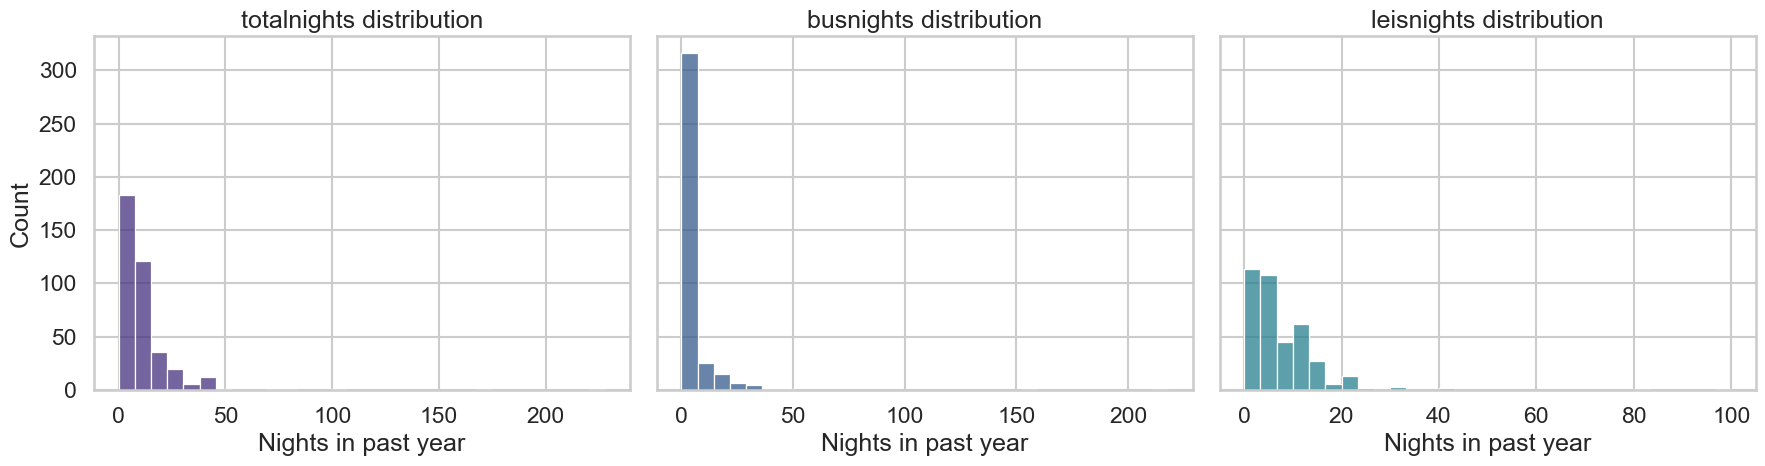

In [4]:
# Summarize business vs leisure travel
trip_cols = ['totalnights','busnights','leisnights']
trip_summary = df[trip_cols].describe().T[['count','mean','50%','75%','max']]

# Export for Excel
trip_summary.to_csv('exports/trip_summary.csv')

display(trip_summary)

# Plot simple histograms so you can see skew/outliers
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for idx, col in enumerate(trip_cols):
    sns.histplot(df[col], bins=30, ax=ax[idx], color=sns.color_palette('viridis')[idx])
    ax[idx].set_title(f'{col} distribution')
    ax[idx].set_xlabel('Nights in past year')
plt.tight_layout()
plt.show()


## 4) Meridien engagement
Purpose: See how many Meridien nights people report.
What to look at: The count plot and summary table.
Export: `exports/meridien_nights_summary.csv`.


,count,mean,50%,75%,max
Meridiennights,361.00,1.12,1.00,1.00,5.00


/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_61512/2006724713.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Meridiennights', data=df, palette='mako', ax=ax)


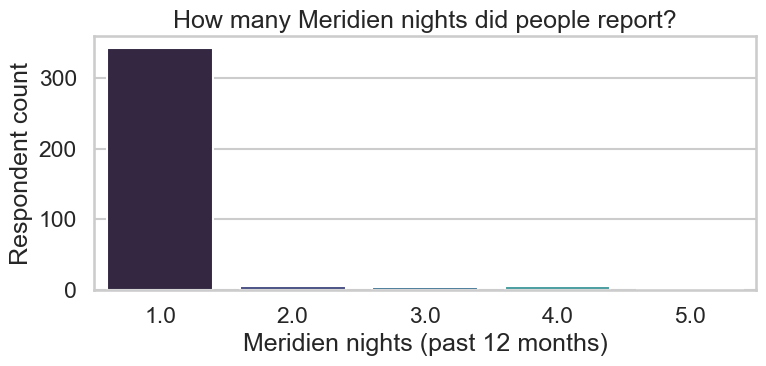

In [5]:
# Summarize Meridien nights
mer_summary = df[['Meridiennights']].describe().T[['count','mean','50%','75%','max']]
mer_summary.to_csv('exports/meridien_nights_summary.csv')

display(mer_summary)

# Count how many people reported each number of Meridien nights
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(x='Meridiennights', data=df, palette='mako', ax=ax)
ax.set_title('How many Meridien nights did people report?')
ax.set_xlabel('Meridien nights (past 12 months)')
ax.set_ylabel('Respondent count')
plt.tight_layout()
plt.show()


## 5) Other brands Meridien guests also use
Purpose: Identify overlap so you can target the right loyalty audiences.
What to look at: The horizontal bar chart and the `overlap_means` table.
Export: `exports/meridien_overlap_means.csv`.


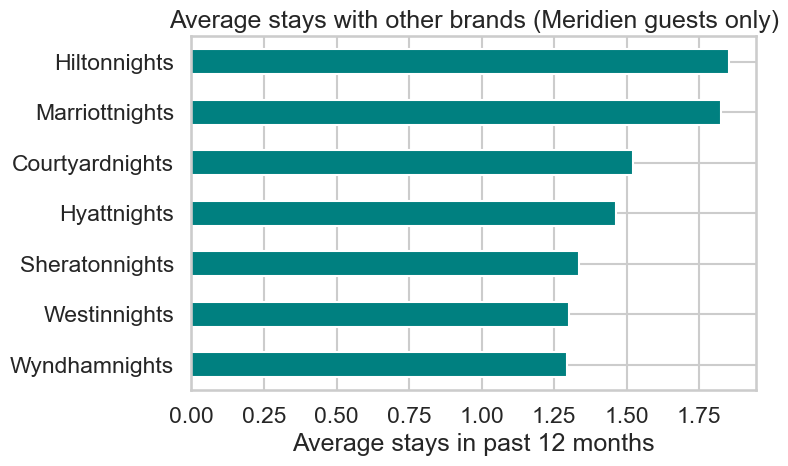

Hiltonnights      1.85
Marriottnights    1.82
Courtyardnights   1.52
Hyattnights       1.46
Sheratonnights    1.33
Westinnights      1.30
Wyndhamnights     1.29
dtype: float64

In [6]:
# Filter to people who stayed with Meridien at least once
with_mer = df[df['Meridiennights'] > 0]

# Average stays with other brands among this group
compare_cols = ['Hyattnights','Hiltonnights','Westinnights','Marriottnights','Sheratonnights','Wyndhamnights','Courtyardnights']
co_means = with_mer[compare_cols].mean().sort_values(ascending=True)
co_means.to_csv('exports/meridien_overlap_means.csv')

# Visualize overlap
fig, ax = plt.subplots(figsize=(8,5))
co_means.plot(kind='barh', color='teal', ax=ax)
ax.set_title('Average stays with other brands (Meridien guests only)')
ax.set_xlabel('Average stays in past 12 months')
plt.tight_layout()
plt.show()

co_means.sort_values(ascending=False)


## 6) Which feelings move Meridien's SCR
Purpose: Learn which opinion statements line up with higher `SCRmerid` scores.
What to look at: The correlation bar chart (higher bars = stronger link) and the sorted table.
Exports: `exports/meridien_correlations.csv` (correlation values) and `exports/meridien_attitude_summary.csv` (basic stats).


Complete Meridien attitude + SCR records: 13


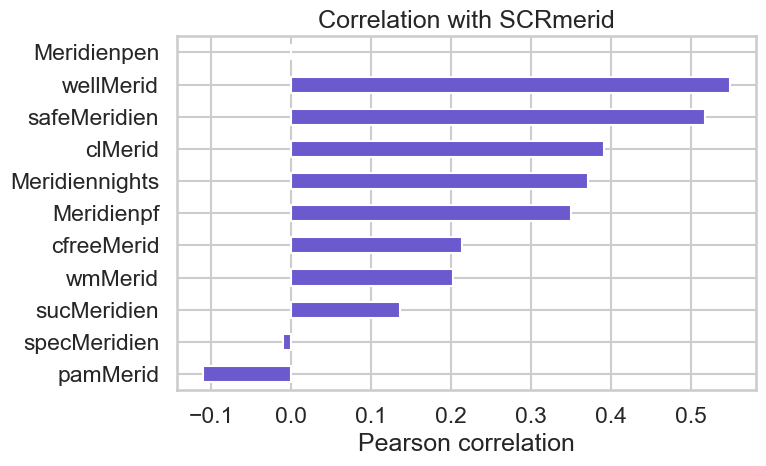

wellMerid         0.55
safeMeridien      0.52
clMerid           0.39
Meridiennights    0.37
Meridienpf        0.35
cfreeMerid        0.21
wmMerid           0.20
sucMeridien       0.14
specMeridien     -0.01
pamMerid         -0.11
Meridienpen        NaN
Name: SCRmerid, dtype: float64

In [7]:
# Keep only rows where every Meridien opinion + SCR field is answered
mer_cols = ['Meridiennights','safeMeridien','sucMeridien','specMeridien','cfreeMerid','wellMerid','clMerid','wmMerid','pamMerid','Meridienpen','Meridienpf','SCRmerid']
mer_stack = df[mer_cols].dropna()
print(f"Complete Meridien attitude + SCR records: {len(mer_stack)}")

# Basic stats so you can inspect ranges
attitude_summary = mer_stack.describe().T
attitude_summary.to_csv('exports/meridien_attitude_summary.csv')

# Correlation of each statement with SCRmerid (directional because sample is small)
corr_series = mer_stack.corr(numeric_only=True)['SCRmerid'].drop('SCRmerid').sort_values()
corr_series.to_csv('exports/meridien_correlations.csv', header=['correlation_with_SCRmerid'])

a = corr_series.plot(kind='barh', color='slateblue', figsize=(8,5))
a.set_title('Correlation with SCRmerid')
a.set_xlabel('Pearson correlation')
plt.tight_layout()
plt.show()

corr_series.sort_values(ascending=False)


## 7) SCR scorecard vs. other premium brands
Purpose: Compare Meridien's advocacy score to close competitors.
What to look at: The SCR summary table and the orange bar chart.
Exports: `exports/scr_summary.csv` (by brand) and `exports/scr_means.csv` (just the averages).


,count,mean,50%,75%,max
SCRmerid,19.00,0.05,0.04,0.06,0.14
SCRhyatt,97.00,0.22,0.15,0.30,1.00
SCRhilt,161.00,0.29,0.20,0.35,1.00
SCRwestin,54.00,0.14,0.10,0.16,1.00
SCRmarriott,176.00,0.26,0.20,0.34,1.00
SCRsher,67.00,0.18,0.11,0.22,1.00


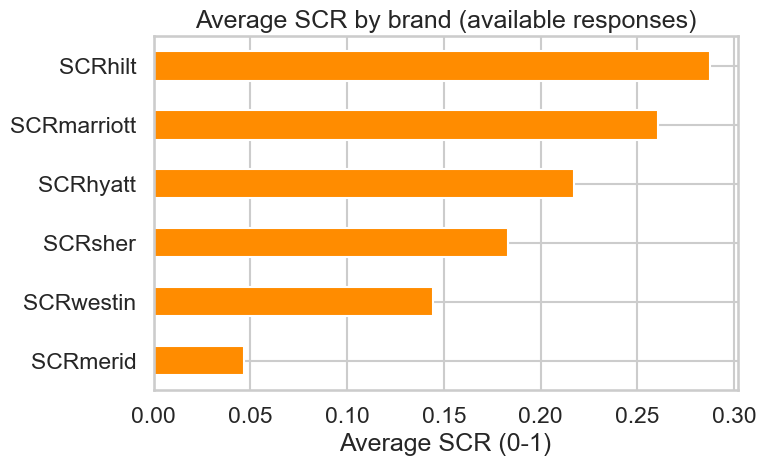

In [8]:
# Compare SCR scores for Meridien vs. peer brands
scr_cols = ['SCRmerid','SCRhyatt','SCRhilt','SCRwestin','SCRmarriott','SCRsher']
scr_summary = df[scr_cols].describe().T[['count','mean','50%','75%','max']]
scr_summary.to_csv('exports/scr_summary.csv')

display(scr_summary)

# Bar chart of average SCR per brand
scr_means = df[scr_cols].mean().sort_values()
scr_means.to_csv('exports/scr_means.csv', header=['average_SCR'])

ax = scr_means.plot(kind='barh', color='darkorange', figsize=(8,5))
ax.set_title('Average SCR by brand (available responses)')
ax.set_xlabel('Average SCR (0-1)')
plt.tight_layout()
plt.show()


## 8) Penalty vs. preference (do people avoid or prefer Meridien?)
Purpose: Separate outright rejection (penalty) from first-choice intent (preference).
What to look at: The two boxplots plus the intent summary table.
Export: `exports/meridien_intent_summary.csv`.


,count,mean,50%,75%,max
Meridienpen,361.00,0.05,0.00,0.00,1.00
Meridienpf,19.00,3.97,3.50,5.50,8.00


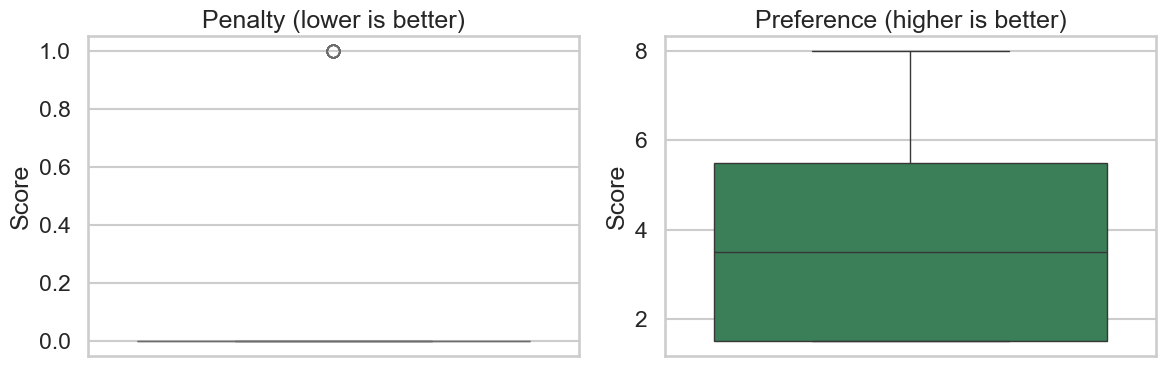

In [9]:
# Penalty = avoid brand; Preference = first choice
intent_cols = ['Meridienpen','Meridienpf']
intent_summary = df[intent_cols].describe().T[['count','mean','50%','75%','max']]
intent_summary.to_csv('exports/meridien_intent_summary.csv')

display(intent_summary)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(y=df['Meridienpen'], ax=ax[0], color='salmon')
ax[0].set_title('Penalty (lower is better)')
ax[0].set_ylabel('Score')

sns.boxplot(y=df['Meridienpf'].dropna(), ax=ax[1], color='seagreen')
ax[1].set_title('Preference (higher is better)')
ax[1].set_ylabel('Score')

plt.tight_layout()
plt.show()


## 9) Business vs. leisure segments
Purpose: Check whether trip purpose changes Meridien usage or SCR.
What to look at: The segment summary table and the bar chart with average Meridien nights and SCR by segment.
Export: `exports/segment_summary.csv`.


Meridiennights      SCRmerid     
                           count mean    count mean
segment                                            
Balanced/No stays             34 1.18        3 0.03
Business leaning              75 1.13        5 0.03
Leisure leaning              252 1.10       11 0.06

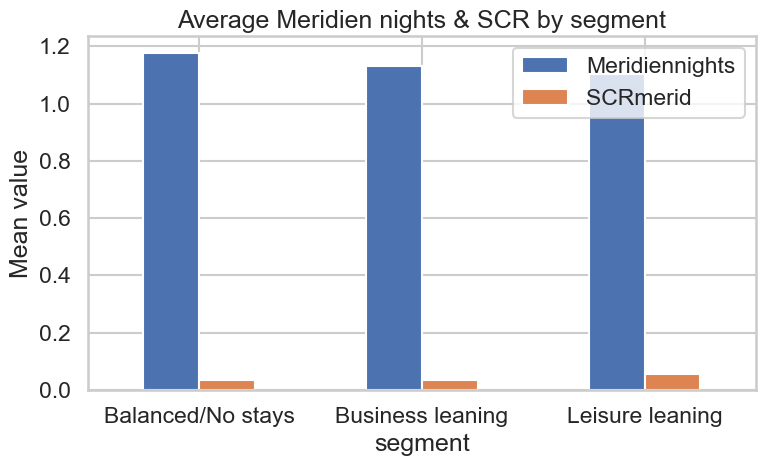

In [10]:
# Create a simple segment label: which trip type is bigger for each person?
segment_df = df[['totalnights','busnights','leisnights','Meridiennights','SCRmerid']].copy()
segment_df['segment'] = np.where(segment_df['busnights'] > segment_df['leisnights'], 'Business leaning',
                          np.where(segment_df['leisnights'] > segment_df['busnights'], 'Leisure leaning', 'Balanced/No stays'))

segment_summary = segment_df.groupby('segment')[['Meridiennights','SCRmerid']].agg(['count','mean'])
segment_summary.to_csv('exports/segment_summary.csv')

display(segment_summary)

segment_means = segment_df.groupby('segment')[['Meridiennights','SCRmerid']].mean()
segment_means.plot(kind='bar', figsize=(8,5), color=['#4c72b0','#dd8452'])
plt.title('Average Meridien nights & SCR by segment')
plt.ylabel('Mean value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 10) How we reached the conclusions (recap)
1) Data quality: We checked missingness first; the Meridien opinion + SCR sample is small, so we treat all stats as directional.
2) Reach vs. advocacy: 361 people stayed with Meridien; only 19 answered `SCRmerid`, and their average was 0.047, so awareness/engagement is the bottleneck, not active dislike.
3) Drivers: Correlation bars showed `wellMerid` (welcomed/well) and `safeMeridien` leading; these feelings align most with higher SCR.
4) Overlap: The overlap table showed Hilton and Marriott as the next-most-used brands for Meridien stayers; those loyalty pools are the fastest win.
5) Intent: Penalty scores hovered near zero while preference hovered around the middle of the scale, signaling indifference (room to persuade) rather than rejection.
6) Segments: Leisure-leaning travelers posted the highest SCR despite low stay counts, so leisure-focused offers are the quickest path to a better score.
